# Kickstarter ProjectsデータセットによるML実装課題
[1] kaggle Kickstarter Projects(http://www.kaggle.com/kemical/kickstarter-projects)

# 目標：変数stateを目的変数とした分類モデルの構築

# 1. パッケージのインポート

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

import time
import random
import math
from scipy.sparse import vstack, csr_matrix

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import sklearn
from sklearn.linear_model import LogisticRegression, LinearRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import tensorflow as tf
from tensorflow import keras
# keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Layer
from tensorflow.keras.layers import Activation, Dropout, Flatten, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling1D, AveragePooling1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.layers import Conv2D, SeparableConv2D
from tensorflow.keras.layers import Conv1D, SeparableConv1D
from tensorflow.keras.layers import Add, Concatenate, add, concatenate
from tensorflow.keras.losses import mean_squared_error, mean_absolute_error, categorical_crossentropy
from tensorflow.keras.optimizers import Adadelta, Adagrad, Adam, Adamax, Ftrl, Nadam, RMSprop, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, RemoteMonitor, ReduceLROnPlateau
from tensorflow.keras.callbacks import Callback
from keras.wrappers.scikit_learn import KerasClassifier

import category_encoders as ce
import gc

Using TensorFlow backend.


In [2]:
def print_validation_scores(y_true, y_pred):
    print('accuracy = ', accuracy_score(y_true, y_pred))
    print('precision = ', precision_score(y_true, y_pred, average='macro'))
    print('recall = ', recall_score(y_true, y_pred, average='macro'))
    print('f1 score = ', f1_score(y_true, y_pred, average='macro'))
    
    print('confusion matrix = \n', confusion_matrix(y_true, y_pred))
    print('confusion matrix plot:')
    df_mat = pd.DataFrame(confusion_matrix(y_true, y_pred), index = ['0', '1'],
                  columns = ['0', '1'])
    sns.heatmap(df_mat, annot=True)
    

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASSEED'] = str(seed)
    np.random.seed(seed)
    # tensorflow, keras
    tf.random.set_seed(seed)
    session_conf = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1,
        inter_op_parallelism_threads=1
    )
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

In [3]:
data = pd.read_csv('../input/kickstarter-projects/ks-projects-201801.csv')
data['deadline'] = pd.to_datetime(data['deadline'])
data['launched'] = pd.to_datetime(data['launched'])
data.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


# 2. データセットの確認・処理

In [4]:
data.columns

Index(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'state', 'backers', 'country',
       'usd pledged', 'usd_pledged_real', 'usd_goal_real'],
      dtype='object')

## 2.1 各カラムの意味
1.  ID              : internal kickstater id
2.  name            : name of priject - A
3.  category        : category
4.  main_category   : category of campaign
5.  currency        : currency used to support
6.  deadline        : deadline for crowdfunding
7.  goal            : goal amount in project currency
8.  launched        : date launched
9.  pledged         : pledged amount in project currency
10. state           : current condition the project is in
11. backers         : number of backers
12. country         : country pledged from
13. usd pledged     : pledged amount in USD conversion by kickstarter
14. usd_pledged_real: pledged amount in USD conversion by Fixer.io API
15. usd_goal_real   : goal amount in USD

## 2.2 不要カラムの削除と理由
* pledged系のカラム
 1. pledged
 2. usd pledged
 3. usd_pledged_real  
 
* backers

クラウドファンディングのデータであることを考えるとstateを予測するにあたって、pledged及びbackersカラムは予め得ることのできないデータであるから。

In [5]:
data.drop(['pledged', 'usd pledged', 'usd_pledged_real', 'backers'], axis=1, inplace=True)

## 2.3 欠損値の確認と処理

In [6]:
data.isnull().sum()

ID               0
name             4
category         0
main_category    0
currency         0
deadline         0
goal             0
launched         0
state            0
country          0
usd_goal_real    0
dtype: int64

データセットのデータ量に対して欠損値を含むデータが非常に少ないので全部削除

In [7]:
data = data.dropna()

## 2.4 データの分析

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 378657 entries, 0 to 378660
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   ID             378657 non-null  int64         
 1   name           378657 non-null  object        
 2   category       378657 non-null  object        
 3   main_category  378657 non-null  object        
 4   currency       378657 non-null  object        
 5   deadline       378657 non-null  datetime64[ns]
 6   goal           378657 non-null  float64       
 7   launched       378657 non-null  datetime64[ns]
 8   state          378657 non-null  object        
 9   country        378657 non-null  object        
 10  usd_goal_real  378657 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1), object(6)
memory usage: 34.7+ MB


In [9]:
data.describe()

,ID,goal,usd_goal_real
count,3.786570e+05,3.786570e+05,3.786570e+05
mean,1.074732e+09,4.908068e+04,4.545425e+04
std,6.190872e+08,1.183397e+06,1.152956e+06
min,5.971000e+03,1.000000e-02,1.000000e-02
25%,5.382499e+08,2.000000e+03,2.000000e+03
50%,1.075276e+09,5.200000e+03,5.500000e+03
75%,1.610149e+09,1.600000e+04,1.550000e+04
max,2.147476e+09,1.000000e+08,1.663614e+08


数値データの相関プロット

<AxesSubplot:>

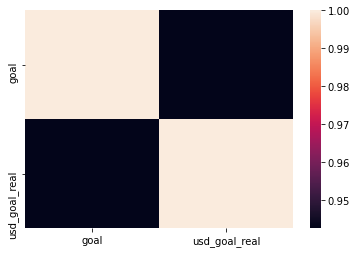

In [10]:
sns.heatmap(data.drop('ID', axis=1).corr())

In [11]:
print(f'data shape: {data.shape}')
for col in data.columns:
    if data[col].dtype == 'object':
        print(f'{col} number of uniques: {data[col].nunique()}')

data shape: (378657, 11)
name number of uniques: 375764
category number of uniques: 159
main_category number of uniques: 15
currency number of uniques: 14
state number of uniques: 6
country number of uniques: 23


カラム内ユニークラベルの意味から、以下のラベルを持つデータを削除。successful or not successful(failed/canceled)を予測する
* live (今アクティブなクラウドファンディング)
* suspended (停止中：まだ終わってない)
* undefined (未定義?)

In [12]:
data = data[(data.state!='live') & (data.state!='undefined') & (data.state!='suspended')].reset_index(drop=True)

(array([197716.,      0.,      0.,      0.,      0.,  38779.,      0.,
             0.,      0., 133956.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

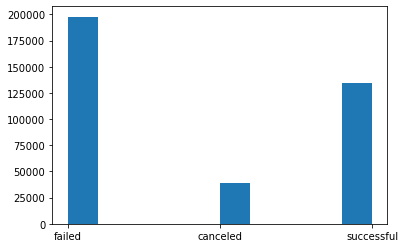

In [13]:
plt.hist(data.state)

### 2.4.1 nameカラム

In [14]:
data.name.unique()

array(['The Songs of Adelaide & Abullah',
       'Greeting From Earth: ZGAC Arts Capsule For ET', 'Where is Hank?',
       ...,
       'Walls of Remedy- New lesbian Romantic Comedy feature unlike any other!!',
       'BioDefense Education Kit', 'Nou Renmen Ayiti!  We Love Haiti!'],
      dtype=object)

In [15]:
# 2765組の重複したプロジェクト名がある
data[data.duplicated(subset=['name'], keep='first')]

,ID,name,category,main_category,currency,deadline,goal,launched,state,country,usd_goal_real
6240,1032645935,Cancelled (Canceled),Design,Design,USD,2015-06-05,100000.0,2015-05-06 12:29:08,canceled,US,100000.00
8175,1042208764,The Basement,Horror,Film & Video,USD,2015-05-07,12000.0,2015-04-07 18:24:19,successful,US,12000.00
8265,1042642941,The Gift,Film & Video,Film & Video,USD,2013-05-08,3000.0,2013-04-17 01:55:27,successful,US,3000.00
8572,1044230780,Redemption,Narrative Film,Film & Video,USD,2012-08-25,11000.0,2012-06-26 19:13:21,successful,US,11000.00
9081,1046840222,Quick Quests: TCG,Tabletop Games,Games,USD,2016-09-01,1000.0,2016-08-20 03:31:20,failed,US,1000.00
...,...,...,...,...,...,...,...,...,...,...,...
369944,997542782,Innocent Sin,Indie Rock,Music,USD,2015-01-25,300.0,2014-12-26 18:04:28,successful,US,300.00
370025,997919903,Grassroots,Publishing,Publishing,EUR,2017-09-14,10000.0,2017-08-15 18:36:18,failed,IE,11963.01
370224,998836498,The InAction,Camera Equipment,Technology,USD,2016-07-29,80000.0,2016-06-28 04:00:08,canceled,US,80000.00
370271,999055513,The Last Hurrah,Rock,Music,USD,2012-06-03,5500.0,2012-05-04 15:20:41,successful,US,5500.00


In [16]:
data[data.name=='Romeo & Juliet']

,ID,name,category,main_category,currency,deadline,goal,launched,state,country,usd_goal_real
121700,1631430549,Romeo & Juliet,Plays,Theater,USD,2015-03-21,1500.0,2015-02-19 21:22:38,successful,US,1500.00
186945,1972361772,Romeo & Juliet,Immersive,Theater,GBP,2015-06-01,5000.0,2015-05-01 14:15:19,failed,GB,7665.65
243372,334932599,Romeo & Juliet,Theater,Theater,USD,2012-03-12,5000.0,2012-02-11 05:08:41,failed,US,5000.00
311692,69260412,Romeo & Juliet,Theater,Theater,USD,2011-08-16,2000.0,2011-07-09 18:43:41,failed,US,2000.00
348797,885939116,Romeo & Juliet,Immersive,Theater,CAD,2017-10-02,3000.0,2017-09-12 05:53:52,successful,CA,2385.69
369654,99598621,Romeo & Juliet,Plays,Theater,USD,2017-09-18,3000.0,2017-08-31 16:02:20,successful,US,3000.00


In [17]:
data[data.name=='Homemade Pizza']

,ID,name,category,main_category,currency,deadline,goal,launched,state,country,usd_goal_real
12643,1064894138,Homemade Pizza,Food,Food,GBP,2015-12-19,20.0,2015-11-19 18:20:53,failed,GB,29.82
36055,1186882427,Homemade Pizza,Food,Food,USD,2014-08-10,10.0,2014-07-11 18:48:41,failed,US,10.00
152029,1790139635,Homemade Pizza,Food,Food,GBP,2014-10-26,30.0,2014-09-26 13:34:29,failed,GB,47.91
292102,590140908,Homemade Pizza,Bacon,Food,SEK,2014-11-21,450.0,2014-10-22 21:41:11,failed,SE,60.57
349603,890261459,Homemade Pizza,Food,Food,USD,2014-08-10,20.0,2014-07-11 19:28:12,failed,US,20.00


In [18]:
data[data.name=='The Pitch']

,ID,name,category,main_category,currency,deadline,goal,launched,state,country,usd_goal_real
14486,1074565725,The Pitch,Shorts,Film & Video,GBP,2016-11-11,7000.0,2016-10-12 13:05:01,failed,GB,8861.66
17546,1091088385,The Pitch,Shorts,Film & Video,USD,2011-11-03,11000.0,2011-09-04 06:28:11,failed,US,11000.00
228167,255297628,The Pitch,Experimental,Film & Video,USD,2017-02-28,2500.0,2017-02-08 22:47:09,successful,US,2500.00


In [19]:
data[data.name=='The Gift']

,ID,name,category,main_category,currency,deadline,goal,launched,state,country,usd_goal_real
4899,1025568649,The Gift,Shorts,Film & Video,USD,2014-05-10,4500.0,2014-04-29 03:14:49,successful,US,4500.0
8265,1042642941,The Gift,Film & Video,Film & Video,USD,2013-05-08,3000.0,2013-04-17 01:55:27,successful,US,3000.0
75820,1394078347,The Gift,Shorts,Film & Video,USD,2011-04-09,1500.0,2011-03-09 00:15:36,failed,US,1500.0
132233,168615922,The Gift,Shorts,Film & Video,USD,2011-12-31,10000.0,2011-11-01 02:28:03,failed,US,10000.0


In [20]:
data['name'].value_counts()

New EP/Music Development                                    15
Canceled (Canceled)                                         13
N/A (Canceled)                                              11
Music Video                                                 11
Cancelled (Canceled)                                        10
                                                            ..
Underneath The Bridge (2015) - Short Film                    1
Miniature Building Authority Castle Kickstarter              1
Just trying to make it in the game                           1
Dhaba—bringing Indian Street Food to Cincinnati              1
Phoenix Musical presents Beauty and the Beast (Canceled)     1
Name: name, Length: 367700, dtype: int64

In [21]:
successful_name_counts = data[data.state=='successful']['name'].value_counts()
notsuccessful_name_counts = data[data.state!='successful']['name'].value_counts()

In [22]:
successful_name_counts

A Midsummer Night's Dream                           5
Reflections                                         5
Debut Album                                         5
Artist Residency at the Vermont Studio Center       5
Nocturne                                            4
                                                   ..
The Bloodlust Bunny Collection                      1
Kill the Director!                                  1
The Voyageur                                        1
Miniature Animation Desk/Stylus Holder              1
The Best Dad Ever: Illustrations For a Kids Book    1
Name: name, Length: 133562, dtype: int64

In [23]:
notsuccessful_name_counts

New EP/Music Development                                    14
Canceled (Canceled)                                         13
Music Video                                                 11
N/A (Canceled)                                              11
Cancelled (Canceled)                                        10
                                                            ..
TheNeonGeisha: Vinyl Die Cut Stickers & Giclee Prints        1
Neutral Zone 2                                               1
Diatribes                                                    1
SPY: Real World, Live-Action Espionage                       1
Phoenix Musical presents Beauty and the Beast (Canceled)     1
Name: name, Length: 235047, dtype: int64

### 2.4.2 categoryカラム

In [24]:
data.category.unique()

array(['Poetry', 'Narrative Film', 'Music', 'Film & Video', 'Restaurants',
       'Food', 'Drinks', 'Product Design', 'Documentary', 'Nonfiction',
       'Indie Rock', 'Crafts', 'Games', 'Tabletop Games', 'Design',
       'Comic Books', 'Art Books', 'Fashion', 'Childrenswear', 'Theater',
       'Comics', 'DIY', 'Webseries', 'Animation', 'Food Trucks',
       'Public Art', 'Illustration', 'Photography', 'Pop', 'People',
       'Art', 'Family', 'Fiction', 'Accessories', 'Rock', 'Hardware',
       'Software', 'Weaving', 'Gadgets', 'Web', 'Jazz', 'Ready-to-wear',
       'Festivals', 'Video Games', 'Anthologies', 'Publishing', 'Shorts',
       'Electronic Music', 'Radio & Podcasts', 'Apps', 'Cookbooks',
       'Apparel', 'Metal', 'Comedy', 'Hip-Hop', 'Periodicals', 'Dance',
       'Technology', 'Painting', 'World Music', 'Photobooks', 'Drama',
       'Architecture', 'Young Adult', 'Latin', 'Mobile Games', 'Flight',
       'Fine Art', 'Action', 'Playing Cards', 'Makerspaces', 'Punk',
       

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158]),
 [Text(0, 0, 'Product Design'),
  Text(1, 0, 'Tabletop Games'),
  Text(2, 0, 'Shorts'),
  Text(3, 0

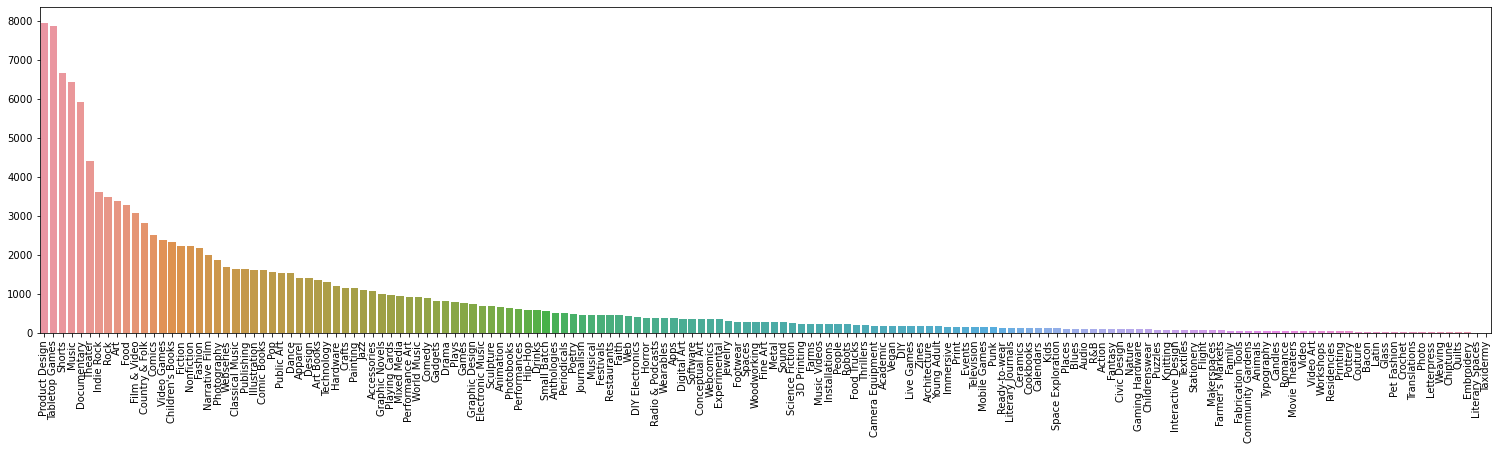

In [25]:
successful_category_counts = data[data.state=='successful']['category'].value_counts()
notsuccessful_category_counts = data[data.state!='successful']['category'].value_counts()
fig = plt.figure(figsize=(26.0, 6.0))
sns.barplot(x=successful_category_counts.index, y=successful_category_counts.values)
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'Product Design'),
  Text(1, 0, 'Documentary'),
  Text(2, 0, 'Video Games'),
  Text(3, 0, 'Food'),
  Text(4, 0, 'Music'),
  Text(5, 0, 'Fiction'),
  Text(6, 0, 'Fashion'),
  Text(7, 0, 'Tabletop Games'),
  Text(8, 0, 'Film & Video'),
  Text(9, 0, 'Nonfiction'),
  Text(10, 0, 'Apps'),
  Text(11, 0, 'Shorts'),
  Text(12, 0, 'Apparel'),
  Text(13, 0, 'Technology'),
  Text(14, 0, 'Art'),
  Text(15, 0, 'Web'),
  Text(16, 0, "Children's Books"),
  Text(17, 0, 'Webseries'),
  Text(18, 0, 'Photography'),
  Text(19, 0, 'Publishing')])

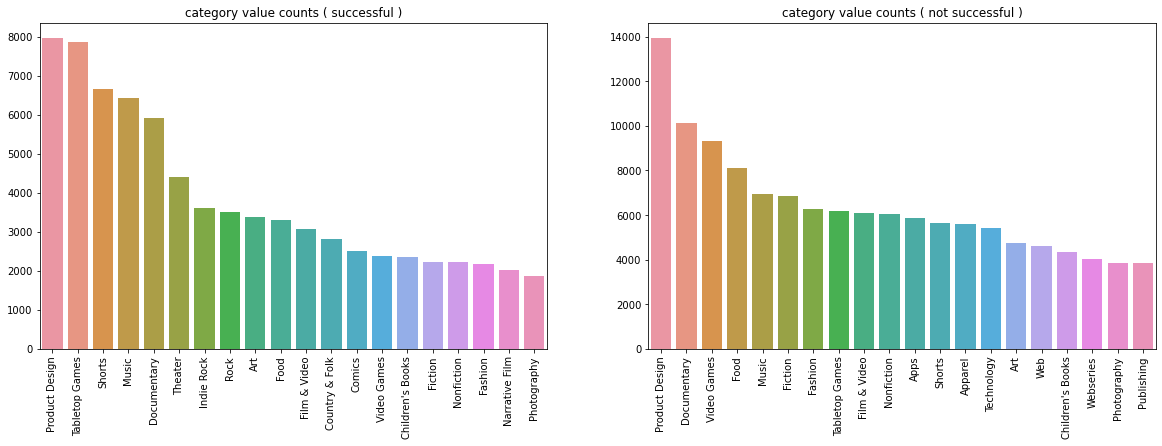

In [26]:
# successful_category_counts = data[data.state=='successful']['category'].value_counts()
# notsuccessful_category_counts = data[data.state!='successful']['category'].value_counts()
fig = plt.figure(figsize=(20.0, 6.0))
plt.subplot(1, 2, 1)
ax = sns.barplot(x=successful_category_counts[:20].index, y=successful_category_counts[:20].values)
ax.set_title('category value counts ( successful )')
plt.xticks(rotation=90)
plt.subplot(1, 2, 2)
ax = sns.barplot(x=notsuccessful_category_counts[:20].index, y=notsuccessful_category_counts[:20].values)
ax.set_title('category value counts ( not successful )')
plt.xticks(rotation=90)

#### 2.4.3 main_categoryカラム

In [27]:
data.main_category.unique()

array(['Publishing', 'Film & Video', 'Music', 'Food', 'Design', 'Crafts',
       'Games', 'Comics', 'Fashion', 'Theater', 'Art', 'Photography',
       'Technology', 'Dance', 'Journalism'], dtype=object)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'Film & Video'),
  Text(1, 0, 'Publishing'),
  Text(2, 0, 'Technology'),
  Text(3, 0, 'Music'),
  Text(4, 0, 'Games'),
  Text(5, 0, 'Design'),
  Text(6, 0, 'Food'),
  Text(7, 0, 'Fashion'),
  Text(8, 0, 'Art'),
  Text(9, 0, 'Photography'),
  Text(10, 0, 'Crafts'),
  Text(11, 0, 'Comics'),
  Text(12, 0, 'Theater'),
  Text(13, 0, 'Journalism'),
  Text(14, 0, 'Dance')])

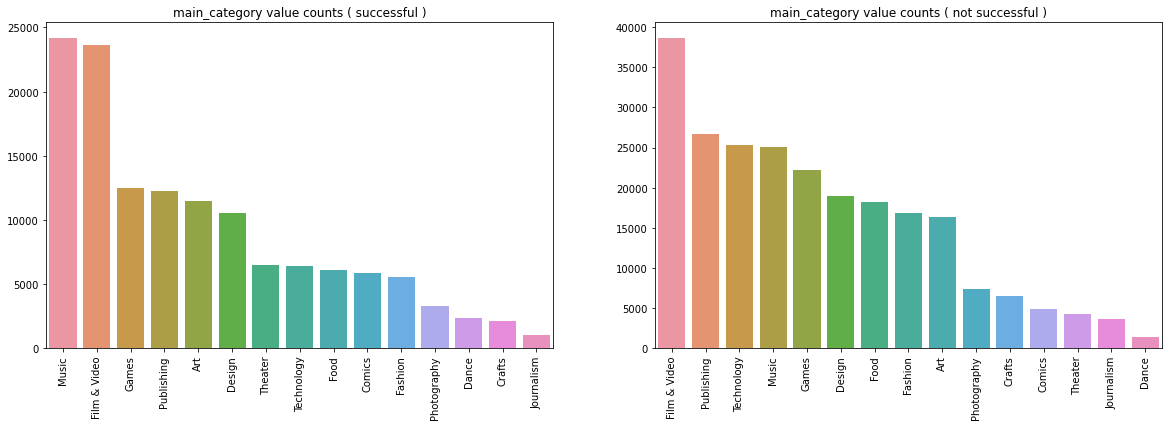

In [28]:
successful_main_category_counts = data[data.state=='successful']['main_category'].value_counts()
notsuccessful_main_category_counts = data[data.state!='successful']['main_category'].value_counts()
fig = plt.figure(figsize=(20.0, 6.0))
plt.subplot(1, 2, 1)
ax = sns.barplot(x=successful_main_category_counts.index, y=successful_main_category_counts.values)
ax.set_title('main_category value counts ( successful )')
plt.xticks(rotation=90)
plt.subplot(1, 2, 2)
ax = sns.barplot(x=notsuccessful_main_category_counts.index, y=notsuccessful_main_category_counts.values)
ax.set_title('main_category value counts ( not successful )')
plt.xticks(rotation=90)

### 2.4.4 currencyカラム

In [29]:
data.currency.unique()

array(['GBP', 'USD', 'CAD', 'AUD', 'NOK', 'EUR', 'MXN', 'SEK', 'NZD',
       'CHF', 'DKK', 'HKD', 'SGD', 'JPY'], dtype=object)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 [Text(0, 0, 'USD'),
  Text(1, 0, 'GBP'),
  Text(2, 0, 'EUR'),
  Text(3, 0, 'CAD'),
  Text(4, 0, 'AUD'),
  Text(5, 0, 'MXN'),
  Text(6, 0, 'SEK'),
  Text(7, 0, 'NZD'),
  Text(8, 0, 'DKK'),
  Text(9, 0, 'CHF'),
  Text(10, 0, 'NOK'),
  Text(11, 0, 'HKD'),
  Text(12, 0, 'SGD'),
  Text(13, 0, 'JPY')])

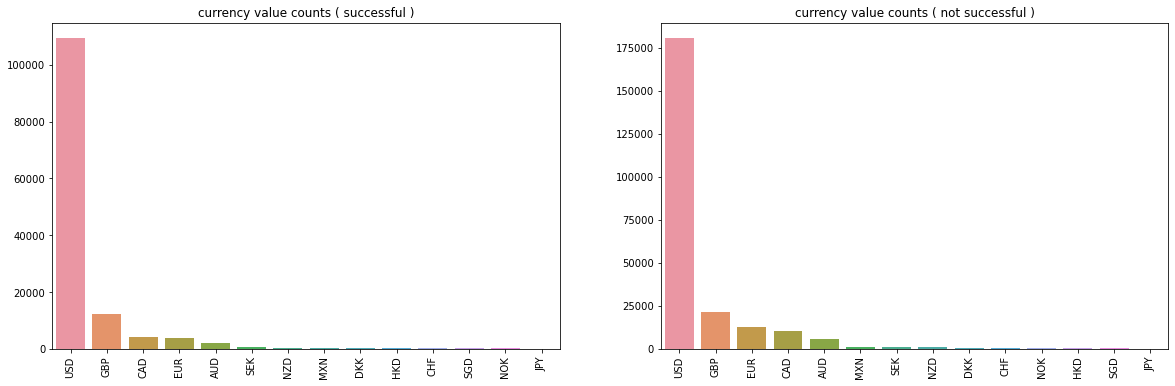

In [30]:
successful_currency_counts = data[data.state=='successful']['currency'].value_counts()
notsuccessful_currency_counts = data[data.state!='successful']['currency'].value_counts()
fig = plt.figure(figsize=(20.0, 6.0))
plt.subplot(1, 2, 1)
ax = sns.barplot(x=successful_currency_counts.index, y=successful_currency_counts.values)
ax.set_title('currency value counts ( successful )')
plt.xticks(rotation=90)
plt.subplot(1, 2, 2)
ax = sns.barplot(x=notsuccessful_currency_counts.index, y=notsuccessful_currency_counts.values)
ax.set_title('currency value counts ( not successful )')
plt.xticks(rotation=90)

USDに偏っているので、使用される通貨の割合でみていくことにすると

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 [Text(0, 0, 'JPY'),
  Text(1, 0, 'EUR'),
  Text(2, 0, 'NOK'),
  Text(3, 0, 'MXN'),
  Text(4, 0, 'CHF'),
  Text(5, 0, 'AUD'),
  Text(6, 0, 'CAD'),
  Text(7, 0, 'SEK'),
  Text(8, 0, 'NZD'),
  Text(9, 0, 'DKK'),
  Text(10, 0, 'SGD'),
  Text(11, 0, 'GBP'),
  Text(12, 0, 'USD'),
  Text(13, 0, 'HKD')])

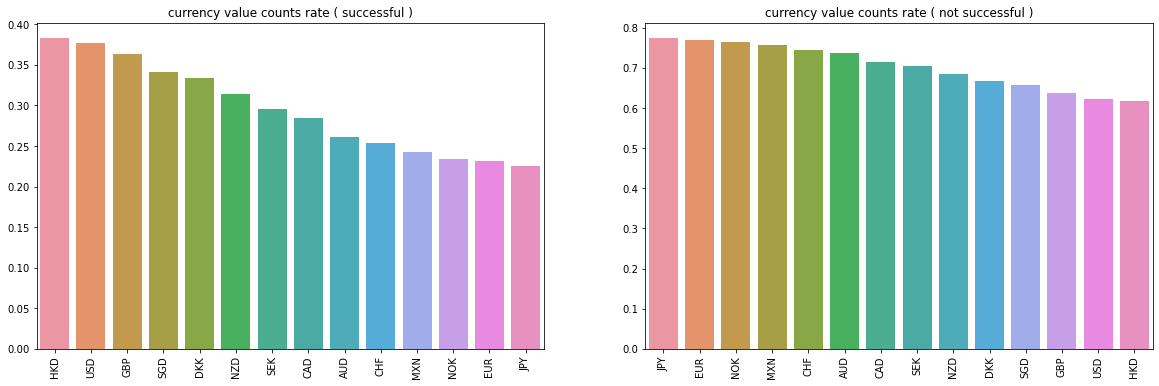

In [31]:
successful_currency = (successful_currency_counts / data.currency.value_counts()).sort_values(ascending=False)
notsuccessful_currency = (notsuccessful_currency_counts / data.currency.value_counts()).sort_values(ascending=False)
fig = plt.figure(figsize=(20.0, 6.0))
plt.subplot(1, 2, 1)
ax = sns.barplot(x=successful_currency.index, y=successful_currency.values)
ax.set_title('currency value counts rate ( successful )')
plt.xticks(rotation=90)
plt.subplot(1, 2, 2)
ax = sns.barplot(x=notsuccessful_currency.index, y=notsuccessful_currency.values)
ax.set_title('currency value counts rate ( not successful )')
plt.xticks(rotation=90)

HKDでの成功数割合がおおい。JPYでは成功しない企画が多い
因みに、各通貨での企画数は

In [32]:
print('HKD: number of projects ', len(data[data.currency=='HKD']))
print('JPY: number of projects ', len(data[data.currency=='JPY']))

HKD: number of projects  564
JPY: number of projects  31


### 2.4.5 goal-usd_goal_realカラム

In [33]:
data['usd_goal_real'].describe()

count    3.704510e+05
mean     4.507610e+04
std      1.128270e+06
min      1.000000e-02
25%      2.000000e+03
50%      5.500000e+03
75%      1.595685e+04
max      1.663614e+08
Name: usd_goal_real, dtype: float64

<AxesSubplot:xlabel='state', ylabel='usd_goal_real'>

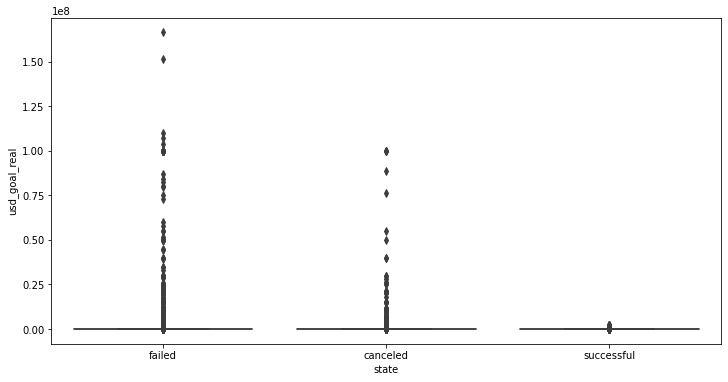

In [34]:
fig = plt.figure(figsize=(12.0, 6.0))
sns.boxplot(x=data['state'], y=data['usd_goal_real'])

つぶれてしまうのでスケールを変える

<AxesSubplot:xlabel='state', ylabel='usd_goal_real'>

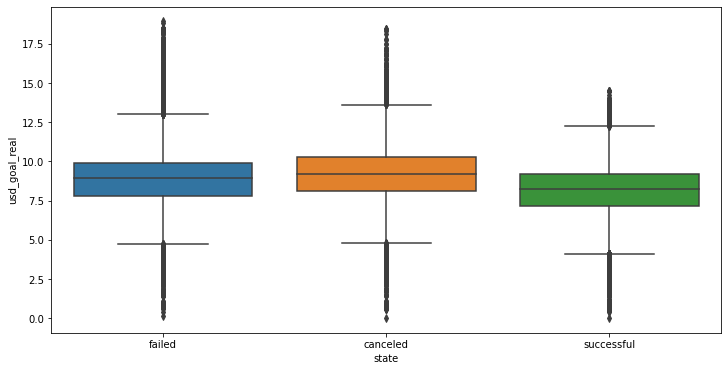

In [35]:
fig = plt.figure(figsize=(12.0, 6.0))
sns.boxplot(x=data['state'], y=np.log1p(data['usd_goal_real']))

成功している企画は、若干目標金額が低めに設定されている。

### 2.4.6 launch-deadlineカラム

In [36]:
print('launched: mean  ', data['launched'].mean())
print('launched: max  ', data['launched'].max())
print('launched: min  ', data['launched'].min())

launched: mean   2014-09-16 02:44:20.967921152
launched: max   2018-01-02 03:05:10
launched: min   1970-01-01 01:00:00


In [37]:
print('deadline: mean  ', data['deadline'].mean())
print('deadline: max  ', data['deadline'].max())
print('deadline: min  ', data['deadline'].min())

deadline: mean   2014-10-19 22:55:03.206029824
deadline: max   2018-02-24 00:00:00
deadline: min   2009-05-03 00:00:00


In [38]:
data['interval'] = data['deadline'] - data['launched']

In [39]:
print('project range: mean  ', data['interval'].mean())
print('project range: max  ', data['interval'].max())
print('project range: min  ', data['interval'].min())

project range: mean   33 days 20:10:42.238142132
project range: max   14866 days 23:00:00
project range: min   0 days 00:07:17


kickstarterの創業は2009年の4月。launchedに1997年があるが、これは明らかにおかしい  
ノイズになりそうな異常値データ(1970年データ)

In [40]:
data[data.launched < '2009-04-01']

,ID,name,category,main_category,currency,deadline,goal,launched,state,country,usd_goal_real,interval
2777,1014746686,Salt of the Earth: A Dead Sea Movie (Canceled),Film & Video,Film & Video,USD,2010-09-15,5000.0,1970-01-01 01:00:00,canceled,US,5000.0,14866 days 23:00:00
47156,1245461087,1st Super-Size Painting - Social Network Owned...,Art,Art,USD,2010-08-14,15000.0,1970-01-01 01:00:00,canceled,US,15000.0,14834 days 23:00:00
73787,1384087152,"""ICHOR"" (Canceled)",Film & Video,Film & Video,USD,2010-05-21,700.0,1970-01-01 01:00:00,canceled,US,700.0,14749 days 23:00:00
92565,1480763647,"Support Solo Theater! Help ""Ungrateful Daughte...",Theater,Theater,USD,2010-06-01,4000.0,1970-01-01 01:00:00,canceled,US,4000.0,14760 days 23:00:00
242574,330942060,"Help RIZ Make A Charity Album: 8 Songs, 8 Caus...",Music,Music,USD,2010-05-04,10000.0,1970-01-01 01:00:00,canceled,US,10000.0,14732 days 23:00:00
267911,462917959,Identity Communications Infographic (Canceled),Design,Design,USD,2010-04-10,500.0,1970-01-01 01:00:00,canceled,US,500.0,14708 days 23:00:00


削除しておく

In [41]:
data = data[data.launched >= '2009-04-01']

時間データを数値化する

In [42]:
data['launched'] = data['launched'].map(pd.Timestamp.to_julian_date)
data['deadline'] = data['deadline'].map(pd.Timestamp.to_julian_date)
data['interval'] = data['deadline'] - data['launched']

<AxesSubplot:xlabel='state', ylabel='interval'>

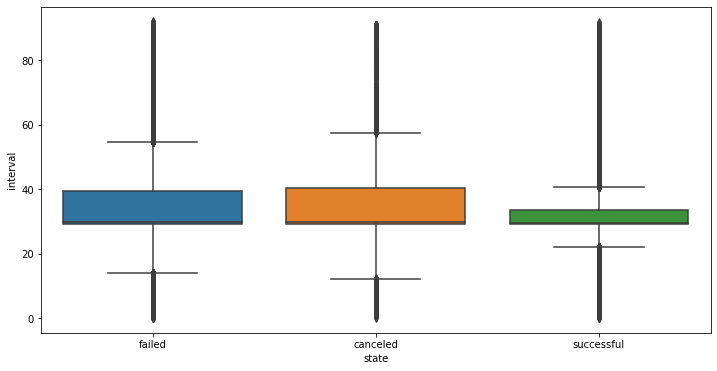

In [43]:
fig = plt.figure(figsize=(12.0, 6.0))
sns.boxplot(x=data['state'], y=data['interval'])

以外にも成功するプロジェクトは支援の受付期間が短い

### 2.4.7 countryカラム

In [44]:
data.country.unique()

array(['GB', 'US', 'CA', 'AU', 'NO', 'IT', 'DE', 'IE', 'MX', 'ES', 'SE',
       'FR', 'NL', 'NZ', 'CH', 'AT', 'BE', 'DK', 'HK', 'LU', 'SG', 'N,0"',
       'JP'], dtype=object)

In [45]:
# N,0"とは
data_N0 = data[data.country=='N,0"']
data_N0[data_N0.duplicated(subset='name', keep=False)]

,ID,name,category,main_category,currency,deadline,goal,launched,state,country,usd_goal_real,interval
129643,1672411097,New EP/Music Development,Music,Music,USD,2457514.5,3000.0,2.457459e+06,failed,"N,0""",3000.0,55.159086
263668,441060346,New EP/Music Development,Music,Music,USD,2457528.5,3000.0,2.457485e+06,failed,"N,0""",3000.0,43.214873


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22]),
 [Text(0, 0, 'US'),
  Text(1, 0, 'GB'),
  Text(2, 0, 'CA'),
  Text(3, 0, 'AU'),
  Text(4, 0, 'DE'),
  Text(5, 0, 'IT'),
  Text(6, 0, 'NL'),
  Text(7, 0, 'FR'),
  Text(8, 0, 'ES'),
  Text(9, 0, 'MX'),
  Text(10, 0, 'SE'),
  Text(11, 0, 'NZ'),
  Text(12, 0, 'DK'),
  Text(13, 0, 'IE'),
  Text(14, 0, 'CH'),
  Text(15, 0, 'NO'),
  Text(16, 0, 'AT'),
  Text(17, 0, 'BE'),
  Text(18, 0, 'HK'),
  Text(19, 0, 'SG'),
  Text(20, 0, 'N,0"'),
  Text(21, 0, 'LU'),
  Text(22, 0, 'JP')])

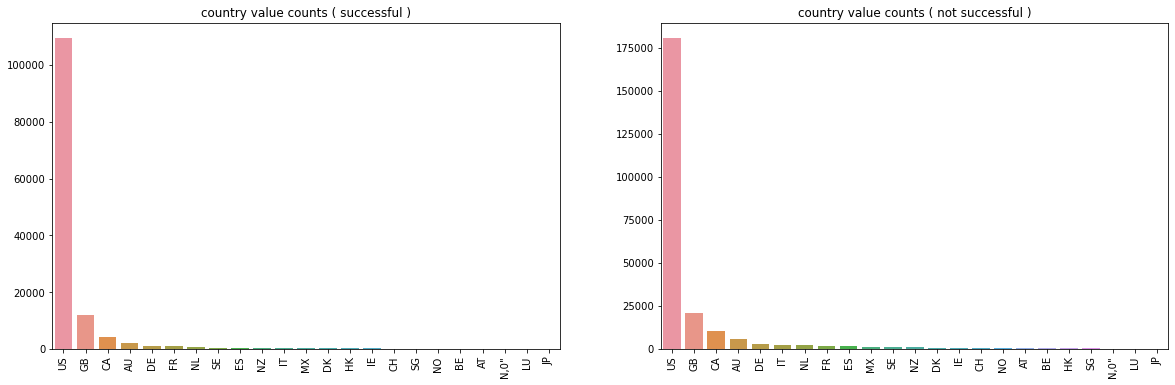

In [46]:
successful_country_counts = data[data.state=='successful']['country'].value_counts()
notsuccessful_country_counts = data[data.state!='successful']['country'].value_counts()
fig = plt.figure(figsize=(20.0, 6.0))
plt.subplot(1, 2, 1)
ax = sns.barplot(x=successful_country_counts.index, y=successful_country_counts.values)
ax.set_title('country value counts ( successful )')
plt.xticks(rotation=90)
plt.subplot(1, 2, 2)
ax = sns.barplot(x=notsuccessful_country_counts.index, y=notsuccessful_country_counts.values)
ax.set_title('country value counts ( not successful )')
plt.xticks(rotation=90)

圧倒的にUSがおおくて、解釈に困る。各国のプロジェクト数で割ったものを算出してみる。
つまり、ある国の人の企画が成功(失敗)した案件数/その国の人が今まで企画してきた案件数。
この方法であれば国ごとに特徴が見れるはず

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22]),
 [Text(0, 0, 'IT'),
  Text(1, 0, 'AT'),
  Text(2, 0, 'NL'),
  Text(3, 0, 'ES'),
  Text(4, 0, 'JP'),
  Text(5, 0, 'DE'),
  Text(6, 0, 'NO'),
  Text(7, 0, 'MX'),
  Text(8, 0, 'CH'),
  Text(9, 0, 'BE'),
  Text(10, 0, 'IE'),
  Text(11, 0, 'AU'),
  Text(12, 0, 'CA'),
  Text(13, 0, 'SE'),
  Text(14, 0, 'LU'),
  Text(15, 0, 'NZ'),
  Text(16, 0, 'FR'),
  Text(17, 0, 'DK'),
  Text(18, 0, 'SG'),
  Text(19, 0, 'GB'),
  Text(20, 0, 'US'),
  Text(21, 0, 'HK'),
  Text(22, 0, 'N,0"')])

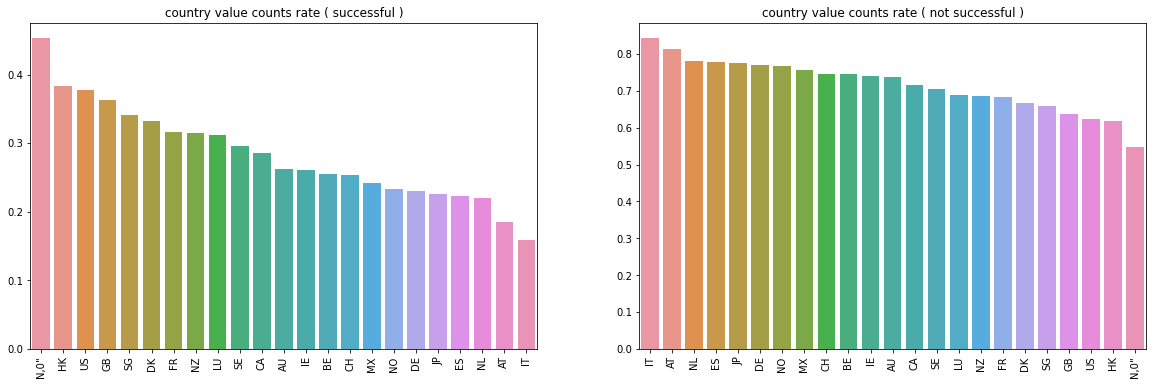

In [47]:
successful_country = (successful_country_counts / data.country.value_counts()).sort_values(ascending=False)
notsuccessful_country = (notsuccessful_country_counts / data.country.value_counts()).sort_values(ascending=False)
fig = plt.figure(figsize=(20.0, 6.0))
plt.subplot(1, 2, 1)
ax = sns.barplot(x=successful_country.index, y=successful_country.values)
ax.set_title('country value counts rate ( successful )')
plt.xticks(rotation=90)
plt.subplot(1, 2, 2)
ax = sns.barplot(x=notsuccessful_country.index, y=notsuccessful_country.values)
ax.set_title('country value counts rate ( not successful )')
plt.xticks(rotation=90)

ITが成功しない企画が多い。N,0"は何かわからんが、一番成功率が高い

In [48]:
print('N,0": number of projects ', len(data[data.country=='N,0"']))
print('IT: number of projects ', len(data[data.country=='IT']))

N,0": number of projects  232
IT: number of projects  2775


# 3. 前処理・学習データの作成

ここまでのrawデータに対する処理まとめ
* pledged, usd pledged, usd_pledged_real, backersカラムの除去
* 欠損値を持つプロジェクトデータの除去
* 目的変数stateの分類項目を successful, failed, canceledに限定
* 時間的におかしいプロジェクトの除去
* 時間データをジュリアン時間にした

In [49]:
################ CONFIG ################
# preprocess confing
ID_col = 'ID'
TARGET = 'state'


# train config
SEED = 42
batch_size = 128
epochs = 50
num_classes = 2
cv_fold = 5

es = EarlyStopping(monitor='val_loss',
                   min_delta=0,
                   patience=5,
                   verbose=1,
                   mode='auto',
                   baseline=None,
                   restore_best_weights=True)

# 再現性の確保
seed_everything(SEED)

In [50]:
num_col = []
cat_col = []
for col in data.columns:
    if data[col].dtype == 'object' and col != TARGET:
        cat_col.append(col)
    if (data[col].dtype == 'int' or data[col].dtype == 'float') and col != ID_col:
        num_col.append(col)

categorical dataをダミー変数化

In [51]:
for col in cat_col:
    data[col], _ = data[col].factorize()

目的変数stateに対しての処理  
successful: 0, successful以外: 1(failed: 1, canceled: 1, suspended: 1)

In [52]:
relabeling = {
    'successful': 0,
    'failed': 1,
    'canceled': 1,
    'suspended': 1
}

data['state'] = data['state'].replace(relabeling)

白色化(無相関化・標準化)処理を行う

In [53]:
X = data.drop(['ID', 'state'], axis=1)

# 無相関化
cov = np.cov(X, rowvar=0)
_, S = np.linalg.eig(cov)
X_decorr = np.dot(S.T, X.T).T

# 標準化
std = StandardScaler()
X_std = std.fit_transform(X_decorr)

y = data.state

# yに対して、層化抽出処理で訓練データとテストデータでバランスが崩れないようにする
X_train, X_valid, y_train, y_valid = train_test_split(X_std, y, test_size=0.2, random_state=42, stratify=y)
# nn用
y_tr_nn = keras.utils.to_categorical(y_train, num_classes)
y_vl_nn = keras.utils.to_categorical(y_valid, num_classes)

(array([107165.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 189191.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

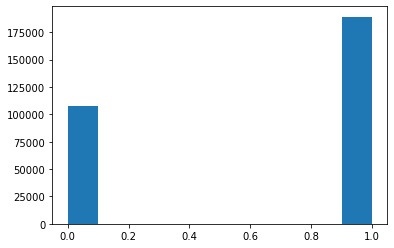

In [54]:
plt.hist(y_train)

(array([26791.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 47298.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

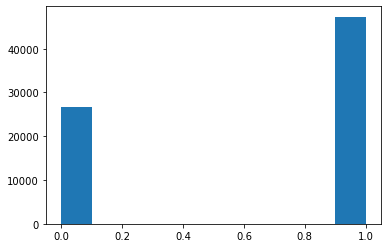

In [55]:
plt.hist(y_valid)

# 4. 各モデルでの学習

#### ロジスティック回帰

In [56]:
logit_clf = LogisticRegression(random_state=SEED)
logit_clf.fit(X_train, y_train)

LogisticRegression(random_state=42)

#### サポートベクトルマシン

In [57]:
# スパースマトリックス化
X_tr, X_vl = csr_matrix(X_train, dtype='float32'), csr_matrix(X_valid, dtype='float32')
svm_clf = LinearSVC(random_state=SEED)
svm_clf.fit(X_tr, y_train)

LinearSVC(random_state=42)

#### 決定木

In [58]:
tree_clf = DecisionTreeClassifier(random_state=SEED)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

#### ランダムフォレスト

In [59]:
rforest_clf = RandomForestClassifier(random_state=SEED, n_jobs=-1)
rforest_clf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

# 5. 作成したモデルの評価

#### ロジスティック回帰

accuracy =  0.6459258459420427
precision =  0.6053687494421447
recall =  0.5273337154537646
f1 score =  0.47156646101232336
confusion matrix = 
 [[ 2649 24142]
 [ 2091 45207]]
confusion matrix plot:


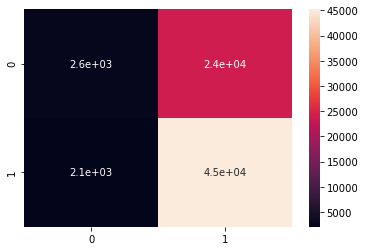

In [60]:
print_validation_scores(y_valid, logit_clf.predict(X_valid))

#### サポートベクトルマシン

accuracy =  0.6430914170794585
precision =  0.6021527494347133
recall =  0.5173133377545247
f1 score =  0.4448178741619166
confusion matrix = 
 [[ 1685 25106]
 [ 1337 45961]]
confusion matrix plot:


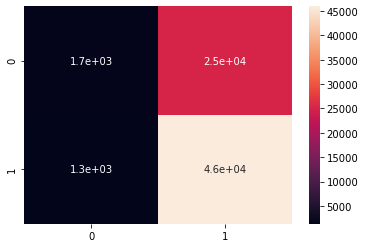

In [61]:
print_validation_scores(y_valid, svm_clf.predict(X_vl))

#### 決定木

accuracy =  0.613640351469179
precision =  0.5829225680745782
recall =  0.583563143961033
f1 score =  0.5832142155063279
confusion matrix = 
 [[12723 14068]
 [14557 32741]]
confusion matrix plot:


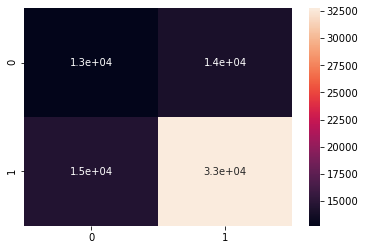

In [62]:
print_validation_scores(y_valid, tree_clf.predict(X_valid))

#### ランダムフォレスト

accuracy =  0.6845820567155718
precision =  0.6533630353085222
recall =  0.6328951285404351
f1 score =  0.6370404352871256
confusion matrix = 
 [[11953 14838]
 [ 8531 38767]]
confusion matrix plot:


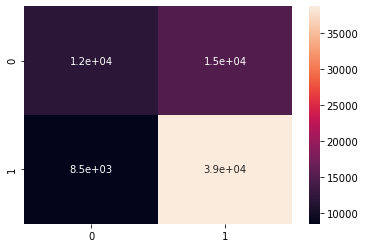

In [63]:
print_validation_scores(y_valid, rforest_clf.predict(X_valid))

# 6. パラメタチューニングによるモデルの改善・学習

今回はグリッドサーチを用いる

In [64]:
def gridsearchCV(sklmodel, params, x_train, y_train, cv=cv_fold):
    gscv = GridSearchCV(sklmodel, params, cv=cv, verbose=2)
    gscv.fit(x_train, y_train)
    best_model = gscv.best_estimator_
    return best_model

#### ロジスティック回帰

In [65]:
logit_params = {
    'penalty':['l1', 'l2', 'elasticnet'],
    'C':[0.1, 1, 10, 100],
}
best_logit = gridsearchCV(LogisticRegression(random_state=SEED, n_jobs=-1), 
                          logit_params, X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] C=0.1, penalty=l1 ...............................................
[CV] ................................ C=0.1, penalty=l1, total=   0.0s
[CV] C=0.1, penalty=l1 ...............................................
[CV] ................................ C=0.1, penalty=l1, total=   0.0s
[CV] C=0.1, penalty=l1 ...............................................
[CV] ................................ C=0.1, penalty=l1, total=   0.0s
[CV] C=0.1, penalty=l1 ...............................................
[CV] ................................ C=0.1, penalty=l1, total=   0.0s
[CV] C=0.1, penalty=l1 ...............................................
[CV] ................................ C=0.1, penalty=l1, total=   0.0s
[CV] C=0.1, penalty=l2 ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ................................ C=0.1, penalty=l2, total=   2.8s
[CV] C=0.1, penalty=l2 ...............................................
[CV] ................................ C=0.1, penalty=l2, total=   2.4s
[CV] C=0.1, penalty=l2 ...............................................
[CV] ................................ C=0.1, penalty=l2, total=   2.4s
[CV] C=0.1, penalty=l2 ...............................................
[CV] ................................ C=0.1, penalty=l2, total=   2.4s
[CV] C=0.1, penalty=l2 ...............................................
[CV] ................................ C=0.1, penalty=l2, total=   2.5s
[CV] C=0.1, penalty=elasticnet .......................................
[CV] ........................ C=0.1, penalty=elasticnet, total=   0.0s
[CV] C=0.1, penalty=elasticnet .......................................
[CV] ........................ C=0.1, penalty=elasticnet, total=   0.0s
[CV] C=0.1, penalty=elasticnet .......................................
[CV] .

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   48.5s finished


#### サポートベクトルマシン

In [66]:
svm_params = {
    'C':[1, 10, 100],
}
best_linearsvm = gridsearchCV(LinearSVC(random_state=SEED), 
                          svm_params, X_tr, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] C=1 .............................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................................. C=1, total=  40.8s
[CV] C=1 .............................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   40.7s remaining:    0.0s


[CV] .............................................. C=1, total=  38.9s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=  38.2s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=  40.3s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=  39.3s
[CV] C=10 ............................................................
[CV] ............................................. C=10, total=  38.8s
[CV] C=10 ............................................................
[CV] ............................................. C=10, total=  39.3s
[CV] C=10 ............................................................
[CV] ............................................. C=10, total=  39.1s
[CV] C=10 ............................................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  9.9min finished


#### 決定木

In [67]:
tree_params = {
    'criterion':['gini', 'entropy'],
    'splitter':['best', 'random'],
    'max_depth':np.arange(5, 20, 5),
}
best_tree = gridsearchCV(DecisionTreeClassifier(random_state=SEED), 
                          tree_params, X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] criterion=gini, max_depth=5, splitter=best ......................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....... criterion=gini, max_depth=5, splitter=best, total=   1.4s
[CV] criterion=gini, max_depth=5, splitter=best ......................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV] ....... criterion=gini, max_depth=5, splitter=best, total=   1.4s
[CV] criterion=gini, max_depth=5, splitter=best ......................
[CV] ....... criterion=gini, max_depth=5, splitter=best, total=   1.4s
[CV] criterion=gini, max_depth=5, splitter=best ......................
[CV] ....... criterion=gini, max_depth=5, splitter=best, total=   1.4s
[CV] criterion=gini, max_depth=5, splitter=best ......................
[CV] ....... criterion=gini, max_depth=5, splitter=best, total=   1.4s
[CV] criterion=gini, max_depth=5, splitter=random ....................
[CV] ..... criterion=gini, max_depth=5, splitter=random, total=   0.1s
[CV] criterion=gini, max_depth=5, splitter=random ....................
[CV] ..... criterion=gini, max_depth=5, splitter=random, total=   0.1s
[CV] criterion=gini, max_depth=5, splitter=random ....................
[CV] ..... criterion=gini, max_depth=5, splitter=random, total=   0.1s
[CV] criterion=gini, max_depth=5, splitter=random ....................
[CV] .

[CV] . criterion=entropy, max_depth=15, splitter=random, total=   0.3s


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  1.5min finished


#### ランダムフォレスト

In [69]:
forest_params = {
    'n_estimators':[100, 200, 300, 400, 500],
    'criterion':['gini', 'entropy'],
    'max_depth':np.arange(5, 20, 5),
}
best_forest = gridsearchCV(RandomForestClassifier(random_state=SEED, warm_start=True, n_jobs=-1), 
                          forest_params, X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] criterion=gini, max_depth=5, n_estimators=100 ...................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .... criterion=gini, max_depth=5, n_estimators=100, total=   6.3s
[CV] criterion=gini, max_depth=5, n_estimators=100 ...................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.2s remaining:    0.0s


[CV] .... criterion=gini, max_depth=5, n_estimators=100, total=   4.0s
[CV] criterion=gini, max_depth=5, n_estimators=100 ...................
[CV] .... criterion=gini, max_depth=5, n_estimators=100, total=   4.0s
[CV] criterion=gini, max_depth=5, n_estimators=100 ...................
[CV] .... criterion=gini, max_depth=5, n_estimators=100, total=   4.0s
[CV] criterion=gini, max_depth=5, n_estimators=100 ...................
[CV] .... criterion=gini, max_depth=5, n_estimators=100, total=   4.3s
[CV] criterion=gini, max_depth=5, n_estimators=200 ...................
[CV] .... criterion=gini, max_depth=5, n_estimators=200, total=   7.6s
[CV] criterion=gini, max_depth=5, n_estimators=200 ...................
[CV] .... criterion=gini, max_depth=5, n_estimators=200, total=   7.5s
[CV] criterion=gini, max_depth=5, n_estimators=200 ...................
[CV] .... criterion=gini, max_depth=5, n_estimators=200, total=   7.4s
[CV] criterion=gini, max_depth=5, n_estimators=200 ...................
[CV] .

[CV] ... criterion=gini, max_depth=15, n_estimators=200, total=  14.7s
[CV] criterion=gini, max_depth=15, n_estimators=300 ..................
[CV] ... criterion=gini, max_depth=15, n_estimators=300, total=  21.7s
[CV] criterion=gini, max_depth=15, n_estimators=300 ..................
[CV] ... criterion=gini, max_depth=15, n_estimators=300, total=  21.7s
[CV] criterion=gini, max_depth=15, n_estimators=300 ..................
[CV] ... criterion=gini, max_depth=15, n_estimators=300, total=  21.8s
[CV] criterion=gini, max_depth=15, n_estimators=300 ..................
[CV] ... criterion=gini, max_depth=15, n_estimators=300, total=  21.6s
[CV] criterion=gini, max_depth=15, n_estimators=300 ..................
[CV] ... criterion=gini, max_depth=15, n_estimators=300, total=  21.5s
[CV] criterion=gini, max_depth=15, n_estimators=400 ..................
[CV] ... criterion=gini, max_depth=15, n_estimators=400, total=  28.6s
[CV] criterion=gini, max_depth=15, n_estimators=400 ..................
[CV] .

[CV]  criterion=entropy, max_depth=10, n_estimators=400, total=  30.7s
[CV] criterion=entropy, max_depth=10, n_estimators=400 ...............
[CV]  criterion=entropy, max_depth=10, n_estimators=400, total=  31.1s
[CV] criterion=entropy, max_depth=10, n_estimators=400 ...............
[CV]  criterion=entropy, max_depth=10, n_estimators=400, total=  30.6s
[CV] criterion=entropy, max_depth=10, n_estimators=500 ...............
[CV]  criterion=entropy, max_depth=10, n_estimators=500, total=  38.6s
[CV] criterion=entropy, max_depth=10, n_estimators=500 ...............
[CV]  criterion=entropy, max_depth=10, n_estimators=500, total=  40.1s
[CV] criterion=entropy, max_depth=10, n_estimators=500 ...............
[CV]  criterion=entropy, max_depth=10, n_estimators=500, total=  39.1s
[CV] criterion=entropy, max_depth=10, n_estimators=500 ...............
[CV]  criterion=entropy, max_depth=10, n_estimators=500, total=  39.9s
[CV] criterion=entropy, max_depth=10, n_estimators=500 ...............
[CV]  

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 49.2min finished


# 7. 改善モデルの評価

#### ロジスティック回帰

accuracy =  0.6464657371539635
precision =  0.6065758301815998
recall =  0.528719480080979
f1 score =  0.47477326076247034
confusion matrix = 
 [[ 2768 24023]
 [ 2170 45128]]
confusion matrix plot:


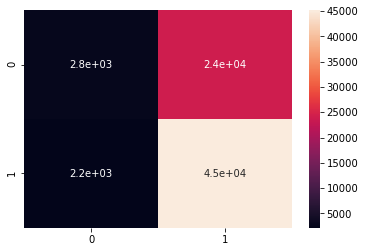

In [70]:
print_validation_scores(y_valid, best_logit.predict(X_valid))

わずかではあるが向上が見られた

#### サポートベクトルマシン

accuracy =  0.6430914170794585
precision =  0.6021527494347133
recall =  0.5173133377545247
f1 score =  0.4448178741619166
confusion matrix = 
 [[ 1685 25106]
 [ 1337 45961]]
confusion matrix plot:


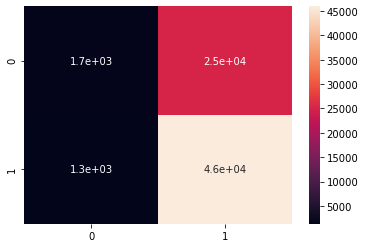

In [71]:
print_validation_scores(y_valid, best_linearsvm.predict(X_vl))

今回計算時間の関係で、線形カーネル、RBFカーネルで関数を分けた。

#### 決定木

accuracy =  0.6743376209693747
precision =  0.6403968607713701
recall =  0.6098047651126761
f1 score =  0.6115889847413836
confusion matrix = 
 [[10091 16700]
 [ 7428 39870]]
confusion matrix plot:


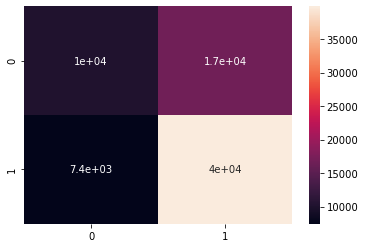

In [72]:
print_validation_scores(y_valid, best_tree.predict(X_valid))

明らかに向上しているのが見て取れる。

#### ランダムフォレスト

accuracy =  0.6951504271889214
precision =  0.673292203839441
recall =  0.6241393796899566
f1 score =  0.6262699843141208
confusion matrix = 
 [[ 9848 16943]
 [ 5643 41655]]
confusion matrix plot:


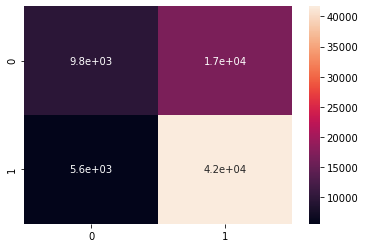

In [73]:
print_validation_scores(y_valid, best_forest.predict(X_valid))

こちらも向上していることがわかる

# 7. ニューラルネットワークでの学習

In [76]:
def MLP(input_shape, lr=0.01):
    
    inputs = Input(shape=input_shape)
    x = Dense(2 ** 6, activation='relu', kernel_initializer='normal')(inputs)
    x = Dense(2 ** 4, activation='relu', kernel_initializer='normal')(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=x)
    model.compile(optimizer=SGD(learning_rate=lr, momentum=0.9, nesterov=True), loss = tf.keras.losses.binary_crossentropy, metrics=['accuracy'])
    
    return model

In [77]:
nn = MLP((X_train.shape[1], ))
nn.fit(X_train, y_tr_nn, batch_size=batch_size,
       epochs=epochs, validation_data=(X_valid, y_vl_nn),
       callbacks=[es],
       verbose=2)

Train on 296356 samples, validate on 74089 samples
Epoch 1/50
296356/296356 - 6s - loss: 0.6394 - accuracy: 0.6403 - val_loss: 0.6311 - val_accuracy: 0.6422
Epoch 2/50
296356/296356 - 5s - loss: 0.6315 - accuracy: 0.6425 - val_loss: 0.6268 - val_accuracy: 0.6427
Epoch 3/50
296356/296356 - 5s - loss: 0.6276 - accuracy: 0.6442 - val_loss: 0.6214 - val_accuracy: 0.6468
Epoch 4/50
296356/296356 - 5s - loss: 0.6242 - accuracy: 0.6459 - val_loss: 0.6186 - val_accuracy: 0.6486
Epoch 5/50
296356/296356 - 5s - loss: 0.6212 - accuracy: 0.6470 - val_loss: 0.6192 - val_accuracy: 0.6441
Epoch 6/50
296356/296356 - 5s - loss: 0.6186 - accuracy: 0.6498 - val_loss: 0.6135 - val_accuracy: 0.6544
Epoch 7/50
296356/296356 - 5s - loss: 0.6173 - accuracy: 0.6505 - val_loss: 0.6097 - val_accuracy: 0.6553
Epoch 8/50
296356/296356 - 5s - loss: 0.6153 - accuracy: 0.6530 - val_loss: 0.6087 - val_accuracy: 0.6586
Epoch 9/50
296356/296356 - 5s - loss: 0.6147 - accuracy: 0.6540 - val_loss: 0.6073 - val_accuracy: 0.

accuracy =  0.6782518322558004
precision =  0.652232279009576
recall =  0.5965980003650966
f1 score =  0.5918326185305383
confusion matrix = 
 [[ 8080 18711]
 [ 5127 42171]]
confusion matrix plot:


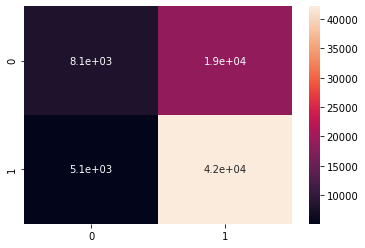

In [78]:
print_validation_scores(y_valid, np.argmax(nn.predict(X_valid), axis=1))